In [1]:
import pandas as pd
import numpy as np
# import seaborn as sns
import cPickle as pickle
import codecs
import skfuzzy as fuzz 

from matplotlib import pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import metrics
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn.cluster.bicluster import SpectralCoclustering
from biclustering.biclustering import DeltaBiclustering
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
# sns.set_palette("deep", desat=.6)
# sns.set_context(rc={"figure.figsize": (8, 4)})

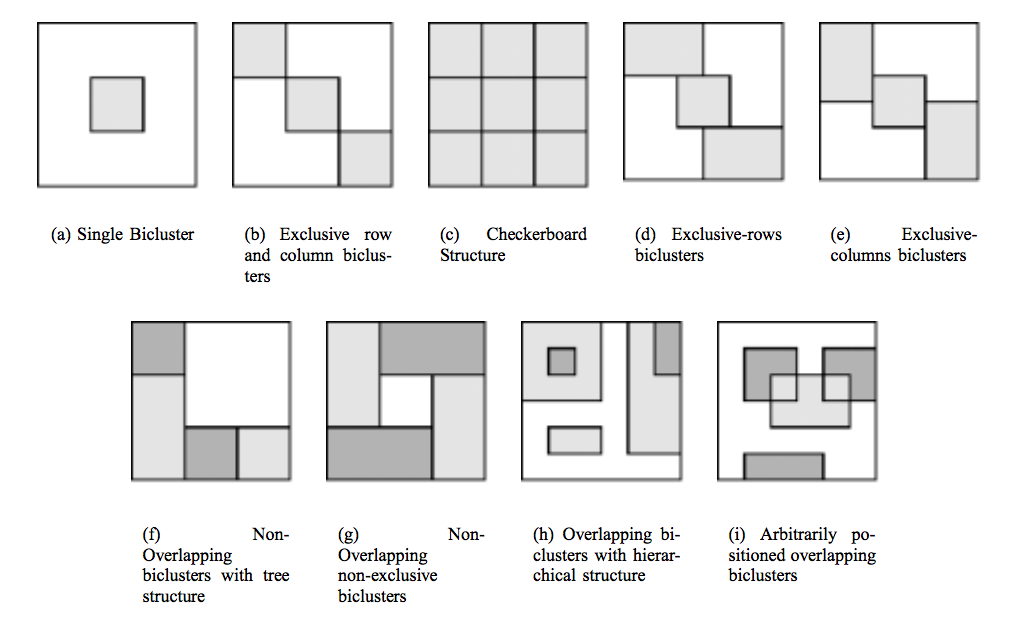

In [3]:
from IPython.core.display import Image 
Image(filename='synteticBiclusters.png')

In [4]:
def generate_dataset(option, noise=1, noise_background=True, shuffle=False):
    shape = (150, 150)
    n, m = shape
    
    # values can't be a lot far...
    centers = [20, 40, 60, 80, 100, 120, 140, 160, 180]
    
    y_row = np.zeros(150)
    y_col = np.zeros(150)

    if noise_background:
        data = np.random.rand(n, m) * 100
    else:
        data = np.zeros(n * m).reshape(shape) + np.random.uniform(0, 1, n*m).reshape(shape)

    if option == 'a':
        data[60:110][:, 70:140] = np.random.rand(50, 70) * noise + centers[0]
        y_row[60:110] = 1
        y_col[70:140] = 1
    elif option == 'b':
        data[0:50][:, 0:50] = np.random.rand(50, 50) * noise + centers[3]
        y_row[0:50] = 0
        y_col[0:50] = 0

        data[50:100][:, 50:100] = np.random.rand(50, 50) * noise + centers[1]
        y_row[50:100] = 1
        y_col[50:100] = 1

        data[100:150][:, 100:150] = np.random.rand(50, 50) * noise + centers[2]
        y_row[100:150] = 2
        y_col[100:150] = 2
    elif option == 'c':
        data[0:50][:, 0:50] = np.random.rand(50, 50) * noise + centers[0]
        y_row[0:50] = 0
        y_col[0:50] = 0

        data[0:50][:, 50:100] = np.random.rand(50, 50) * noise + centers[7]
        y_col[50:100] = 1

        data[0:50][:, 100:150] = np.random.rand(50, 50) * noise + centers[3]
        y_col[100:150] = 2

        data[50:100][:, 0:50] = np.random.rand(50, 50) * noise + centers[2]
        y_row[0:50] = 1

        data[50:100][:, 50:100] = np.random.rand(50, 50) * noise + centers[4]

        data[50:100][:, 100:150] = np.random.rand(50, 50) * noise + centers[8]

        data[100:150][:, 0:50] = np.random.rand(50, 50) * noise + centers[6]
        y_row[100:150] = 2

        data[100:150][:, 50:100] = np.random.rand(50, 50) * noise + centers[1]

        data[100:150][:, 100:150] = np.random.rand(50, 50) * noise + centers[5]
    elif option == 'd':
        data[0:50][:, 0:70] = np.random.rand(50, 70) * noise + centers[0]
        y_row[0:50] = 0
        y_col[0:70] = 0

        data[50:100][:, 50:100] = np.random.rand(50, 50) * noise + centers[2]
        y_row[50:100] = 1
        y_col[50:100] = 1

        data[100:150][:, 80:150] = np.random.rand(50, 70) * noise + centers[1]
        y_row[100:150] = 2
        y_col[80:150] = 2
    elif option == 'e':
        data[0:70][:, 0:50] = np.random.rand(70, 50) * noise + centers[3]
        y_row[0:70] = 0
        y_col[0:50] = 0

        data[50:100][:, 50:100] = np.random.rand(50, 50) * noise + centers[1]
        y_row[50:100] = 1
        y_col[50:100] = 1

        data[80:150][:, 100:150] = np.random.rand(70, 50) * noise + centers[2]
        y_row[80:150] = 2
        y_col[100:150] = 2
    elif option == 'f':
        data[0:50][:, 0:40] = np.random.rand(50, 40) * noise + centers[4]
        y_row[0:50] = 0
        y_col[0:40] = 0

        data[50:150][:, 0:40] = np.random.rand(100, 40) * noise + centers[0]
        y_row[50:150] = 1

        data[110:150][:, 40:95] = np.random.rand(40, 55) * noise + centers[2]
        y_row[110:150] = 2
        y_col[40:95] = 1

        data[110:150][:, 95:150] = np.random.rand(40, 55) * noise + centers[1]
        y_col[95:150] = 2
    elif option == 'g':
        data[0:110][:, 0:40] = np.random.rand(110, 40) * noise + centers[0]
        data[110:150][:, 0:110] = np.random.rand(40, 110) * noise + centers[2]
        data[40:150][:, 110:150] = np.random.rand(110, 40) * noise + centers[1]
        data[0:40][:, 40:150] = np.random.rand(40, 110) * noise + centers[3]
    elif option == 'h':
        data[0:90][:, 0:90] = np.random.rand(90, 90) * noise + centers[0]
        data[35:55][:, 35:55] = (np.random.rand(20, 20) * noise + centers[1]) + data[35:55][:, 35:55]
        data[110:140][:, 35:90] = np.random.rand(30, 55) * noise + centers[4]
        data[0:140][:, 110:150] = np.random.rand(140, 40) * noise + centers[2]
        data[0:55][:, 130:150] = (np.random.rand(55, 20) * noise + centers[3]) + data[0:55][:, 130:150]
    elif option == 'i':
        data[20:70][:, 20:70] = np.random.rand(50, 50) * noise + centers[0]
        data[20:70][:, 100:150] = np.random.rand(50, 50) * noise + centers[1]
        data[50:110][:, 50:120] = np.random.rand(60, 70) * noise + centers[2]
        data[120:150][:, 20:100] = np.random.rand(30, 80) * noise + centers[3]

    if shuffle:
#         np.random.shuffle(data)
        inds = np.random.choice(150, 150, replace=False)
#         np.random.shuffle(data.T)

        return data[inds], y_row[inds], y_col

    return data, y_row, y_col

## Datasets

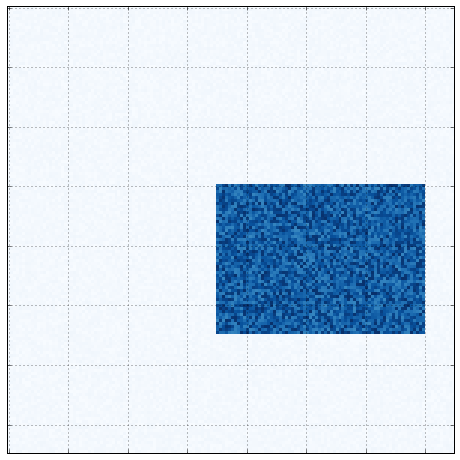

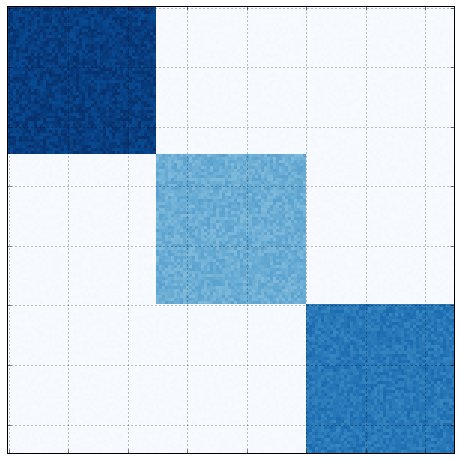

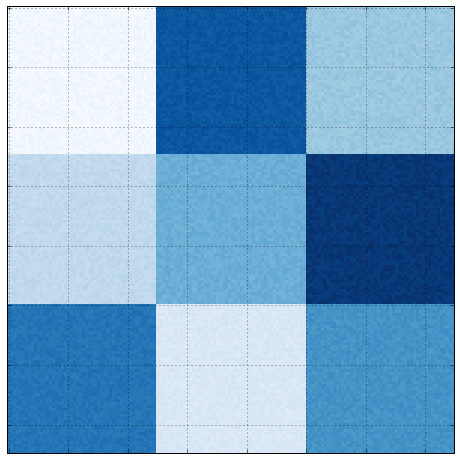

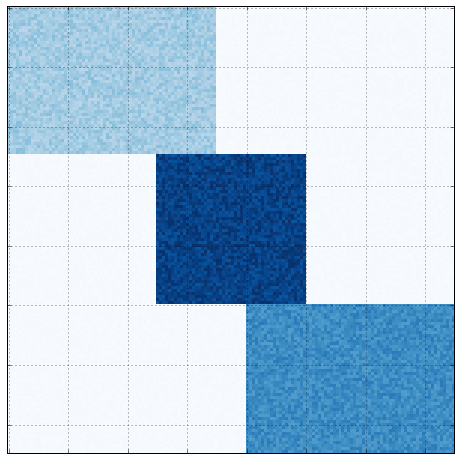

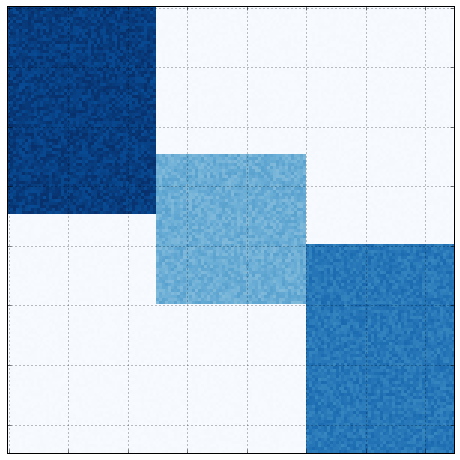

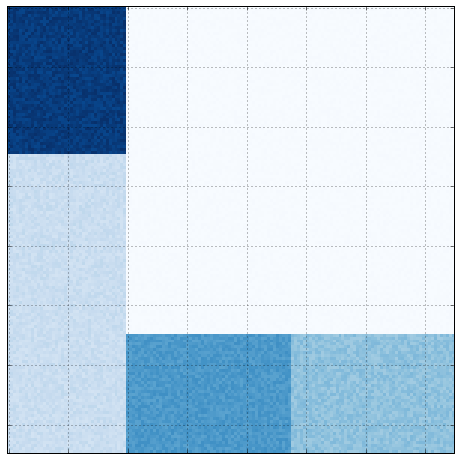

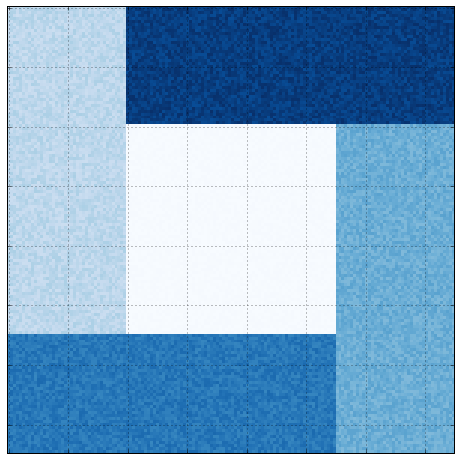

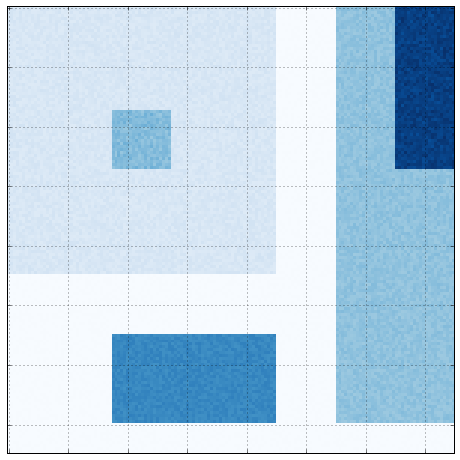

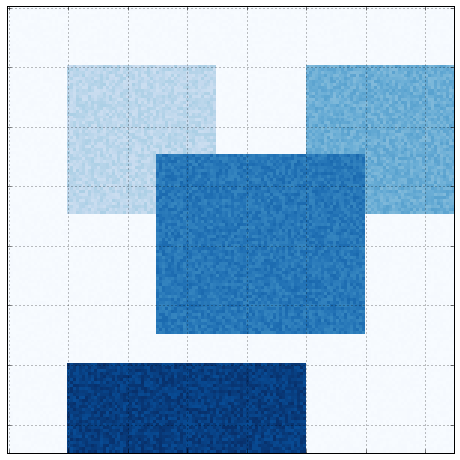

In [5]:
for data_format_option in ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']:
    X, y_row, y_col = generate_dataset(data_format_option, noise=10, noise_background=False)
    plt.matshow(X, cmap=plt.cm.Blues)
    #     plt.axis().set_frame_on(False)
    #     plt.title(data_format_option)
#     plt.axis('off')
    plt.tick_params(labeltop=False, labelbottom=False, labelright=False, labelleft=False)
    plt.grid()
    plt.savefig('/Users/lucasbrunialti/git/masters-dissertation/img/%s-bic-structure.png' % data_format_option)
    plt.show()

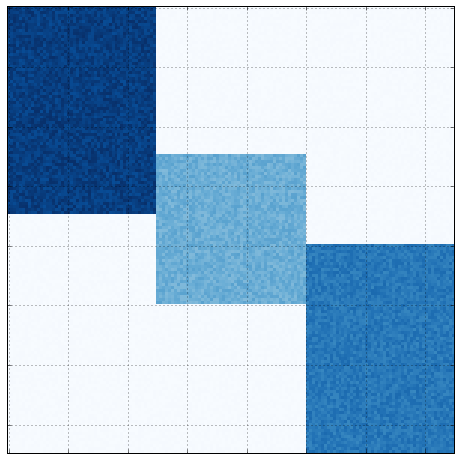

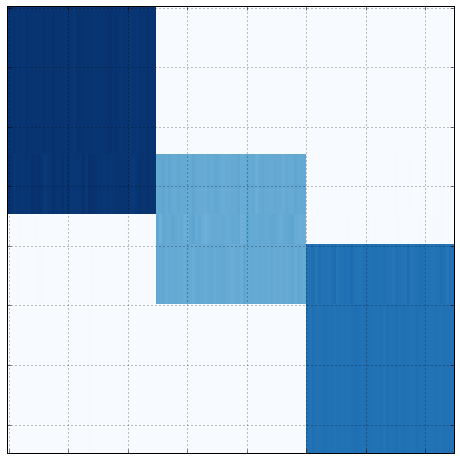

Rand score: 0.752742693832
Quantization error: 76119.9141106
-----------------------------------------------


In [8]:
params = {
    'n_clusters' : {
        'a' : 2, 'b' : 3, 'c' : 3, 'd' : 3, 'e': 5
    }
}

def color_matrix_kmeans(n, m, labels, centroids, X_orig):
    X = np.zeros((n, m))
    labels = labels + 1
    for i, label in enumerate(labels):
        X[i, :] = centroids[label-1, :]

    return X

# for data_format_option in ['a', 'b', 'c', 'd', 'e']:
for data_format_option in ['e']:
    X, y_row, y_col = generate_dataset(data_format_option, noise=10, noise_background=False)
    n, m = X.shape

    plt.matshow(X, cmap=plt.cm.Blues)
    plt.tick_params(labeltop=False, labelbottom=False, labelright=False, labelleft=False)
#     plt.title('Original data %s' % data_format_option)
    plt.grid()
    plt.show()

    estimator = KMeans(n_clusters=params['n_clusters'][data_format_option])
    estimator.fit(X)

    labels = estimator.labels_
    reconstruction = color_matrix_kmeans(n, m, labels, estimator.cluster_centers_, X)

    plt.matshow(reconstruction, cmap=plt.cm.Blues)
#     plt.title('Kmeans reconstruction result')
    plt.tick_params(labeltop=False, labelbottom=False, labelright=False, labelleft=False)
    plt.grid()
    plt.savefig('/Users/lucasbrunialti/git/masters-dissertation/img/%s-reconstruction-2-kmeans.png' % data_format_option)
    plt.show()

    print 'Rand score: %s' % adjusted_rand_score(y_row, labels)
    print 'Quantization error: %s' % estimator.inertia_
    print '-----------------------------------------------'

## Fuzzy K-means

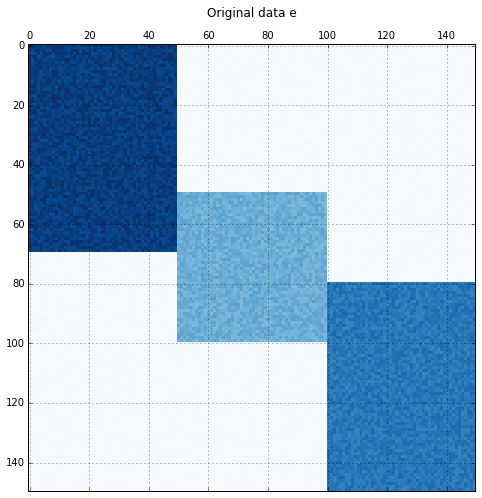

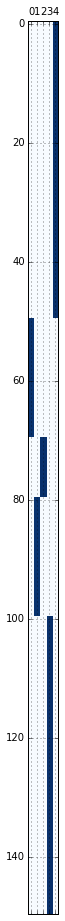

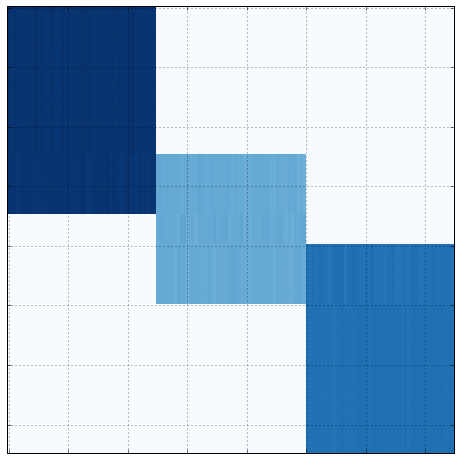

Rand score: 0.752742693832
Quantizatioin error : 76049.0234589
-----------------------------------------------


In [38]:
params = {
    'n_clusters' : {
        'a' : 2, 'b' : 3, 'c' : 3, 'd' : 3, 'e': 5
    }
}

def color_matrix_fuzz_kmeans(n, m, labels, cntr, U):
    return U.T.dot(cntr)

# for data_format_option in ['a', 'b', 'c', 'd', 'e']:
for data_format_option in ['e']:
    X, y_row, y_col = generate_dataset(data_format_option, noise=10, noise_background=False)
    n, m = X.shape

    plt.matshow(X, cmap=plt.cm.Blues)
    plt.title('Original data %s' % data_format_option)
    plt.grid()
    plt.show()

    cntr, U, _, _, jm, _, _ = fuzz.cluster.cmeans(X.T, params['n_clusters'][data_format_option], 2, error=0.0001, maxiter=1000) 
    labels = np.argmax(U, axis=0)
    reconstruction = color_matrix_fuzz_kmeans(n, m, labels, cntr, U)

    plt.matshow(U.T, cmap=plt.cm.Blues)
#     plt.title('Fuzzy Kmeans clusters result')
    plt.grid()
    plt.show()

    plt.matshow(reconstruction, cmap=plt.cm.Blues)
    plt.tick_params(labeltop=False, labelbottom=False, labelright=False, labelleft=False)
    
#     plt.title('Fuzzy Kmeans reconstruction result')
    plt.grid()
#     plt.savefig('/Users/lucasbrunialti/git/masters-dissertation/img/%s-reconstruction-2-fkmeans.png' % data_format_option)
    plt.show()

    print 'Rand score: %s' % adjusted_rand_score(y_row, labels)
    print 'Quantizatioin error : %s' % jm[-1]
    print '-----------------------------------------------'

## Orthogonal Non-negative Matrix Tri-Factorization

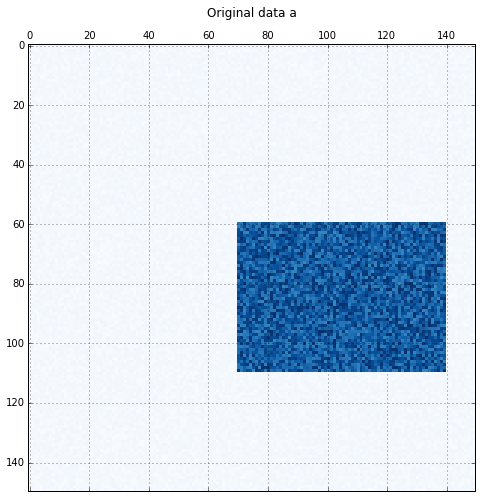

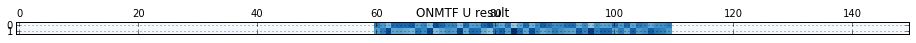

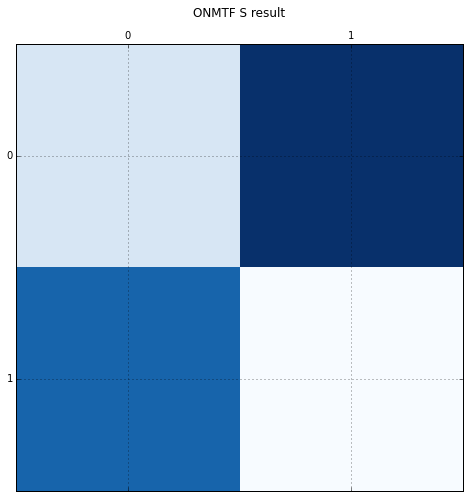

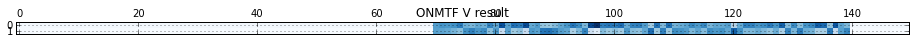

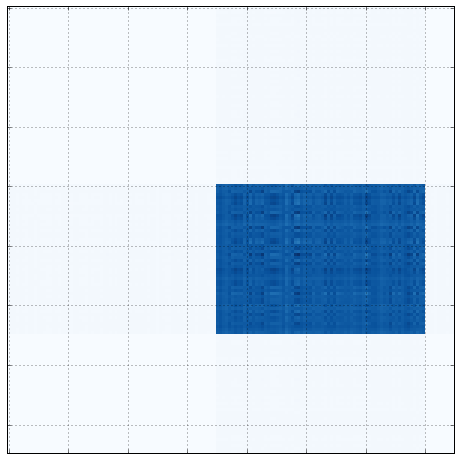

Rand score: 0.25781967061
Error: 30082.32022
-----------------------------------------------


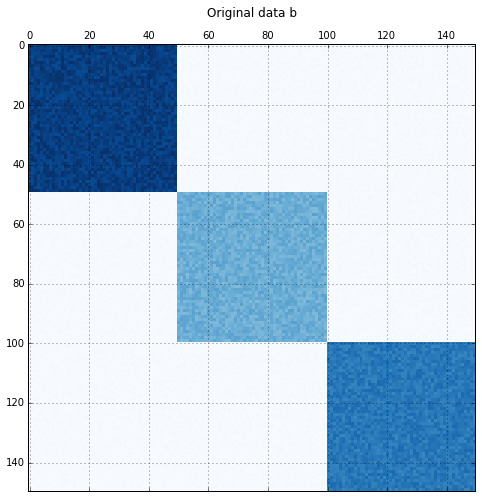

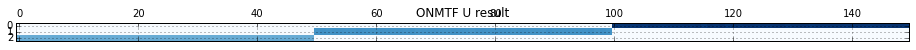

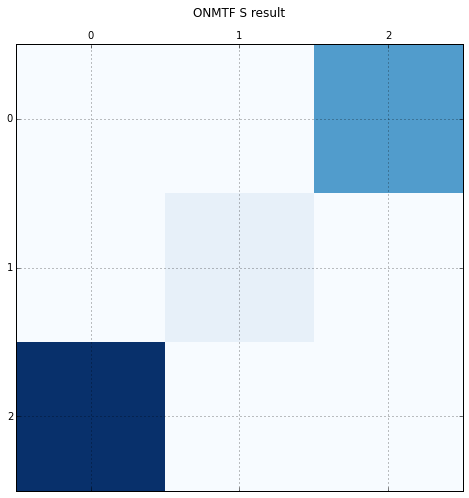

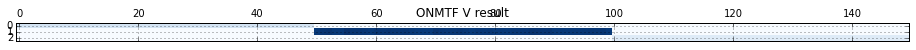

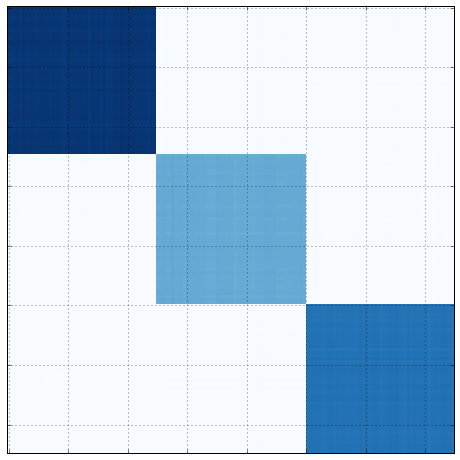

Rand score: 1.0
Error: 61430.8301444
-----------------------------------------------


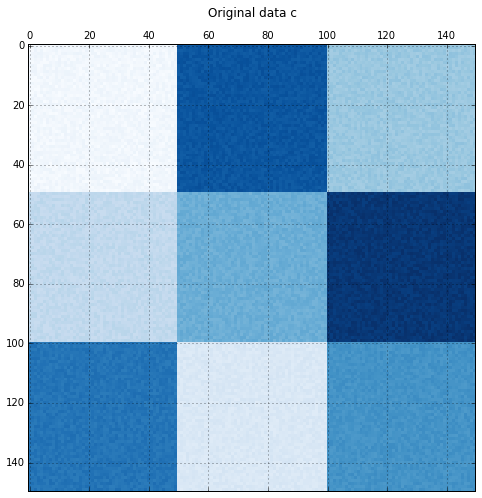

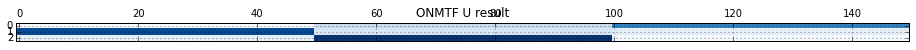

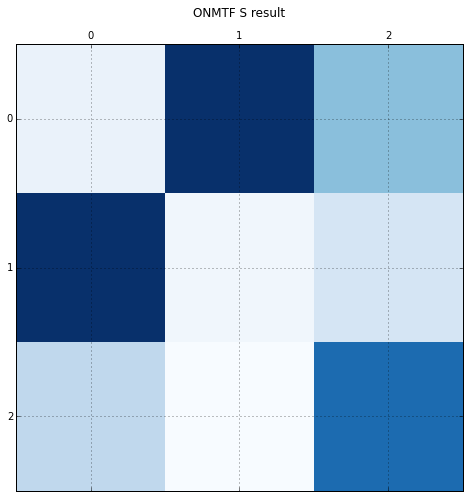

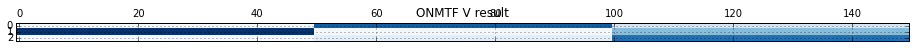

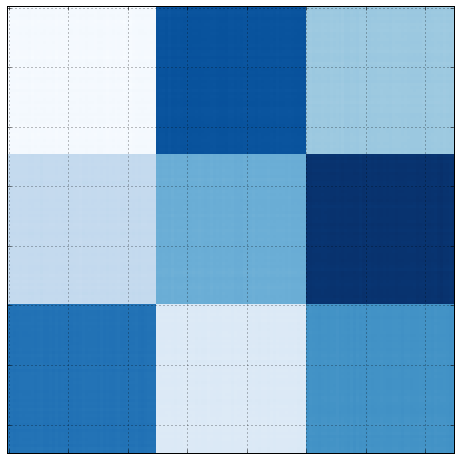

Rand score: 1.0
Error: 181503.708904
-----------------------------------------------


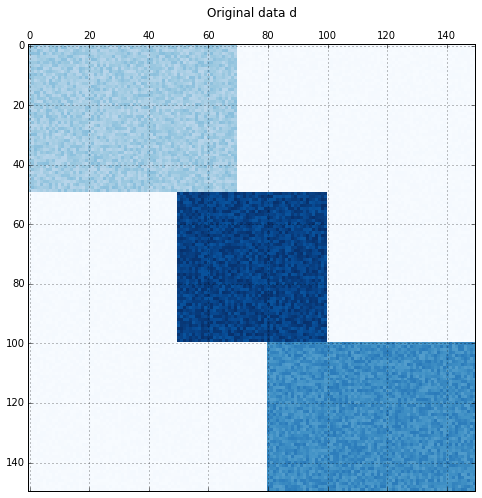

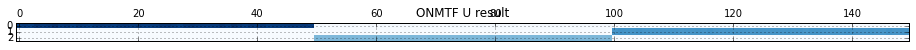

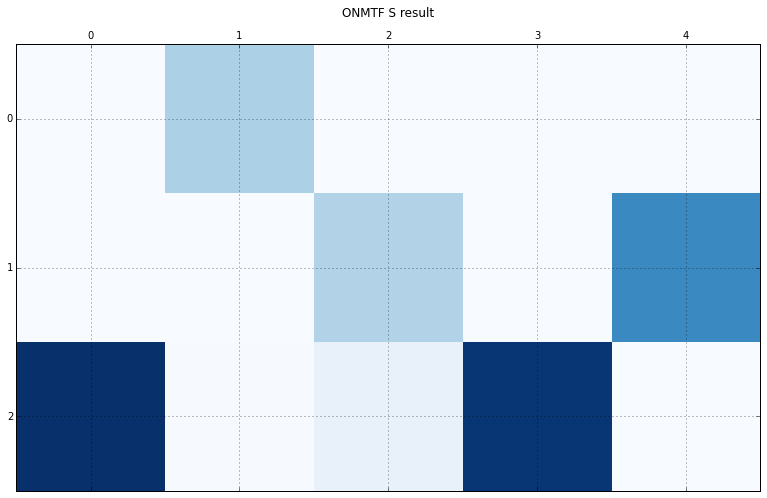

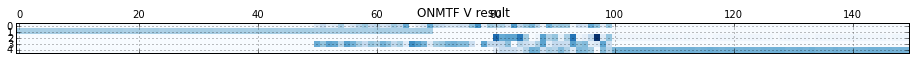

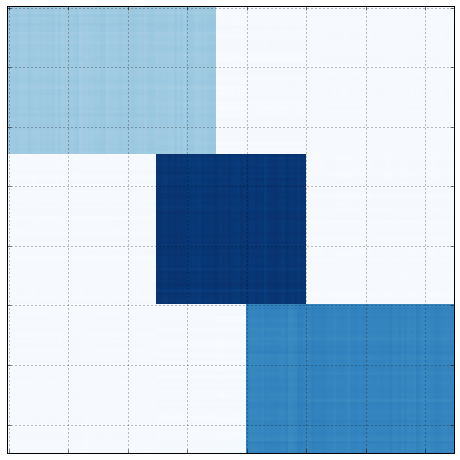

Rand score: 1.0
Error: 76058.6322506
-----------------------------------------------


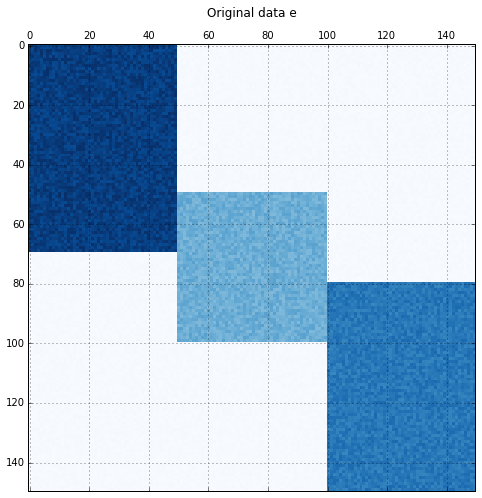

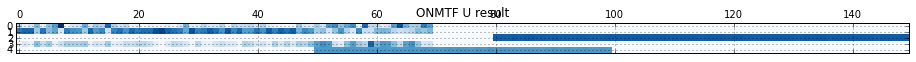

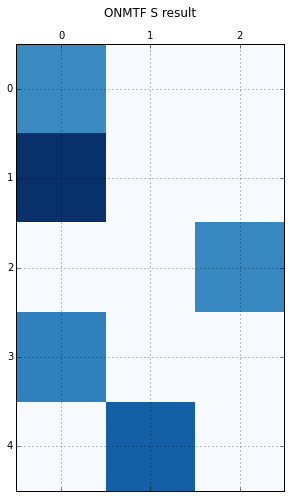

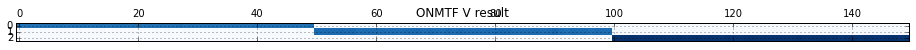

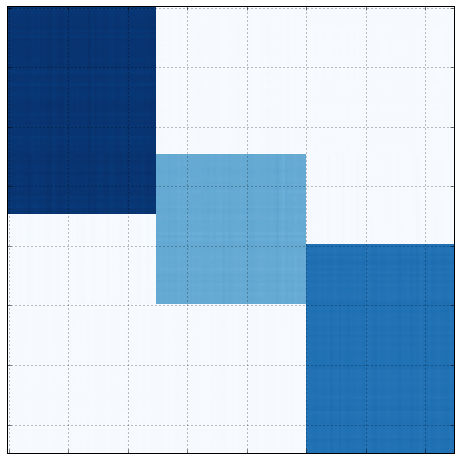

Rand score: 0.887725939686
Error: 77603.3477384
-----------------------------------------------


In [6]:
from __future__ import division 
params = {
    'k' : {
        'a' : 2, 'b' : 3, 'c' : 3, 'd' : 3, 'e': 5
    },
    'l' : {
        'a' : 2, 'b' : 3, 'c' : 3, 'd' : 5, 'e': 3
    }
}

def onmtf(X, U, S, V):
    U = U * ((X.dot(V).dot(S.T)) / (U.dot(S).dot(V.T).dot(X.T).dot(U)))
    V = V * ((X.T.dot(U).dot(S)) / (V.dot(S.T).dot(U.T).dot(X).dot(V)))
    S = S * ((U.T.dot(X).dot(V)) / (U.T.dot(U).dot(S).dot(V.T).dot(V)))
    return U, S, V

def onm3f(X, U, S, V):
     U = U * (X.dot(V).dot(S.T)) / np.sqrt(U.dot(U.T).dot(X).dot(V).dot(S.T))
     V = V * (X.T.dot(U).dot(S)) / np.sqrt(V.dot(V.T).dot(X.T).dot(U).dot(S))
     S = S * (U.T.dot(X).dot(V)) / np.sqrt(U.T.dot(U).dot(S).dot(V.T).dot(V))
     return U, S, V

def nbvd(X, U, S, V):
     U = U * (X.dot(V).dot(S.T)) / U.dot(S).dot(V.T).dot(V).dot(S.T)
     V = V * (X.T.dot(U).dot(S)) / V.dot(S.T).dot(U.T).dot(U).dot(S)
     S = S * (U.T.dot(X).dot(V)) / U.T.dot(U).dot(S).dot(V.T).dot(V)
     return U, S, V
    
def matrix_factorization_clustering(X, k, l, factorization_func=onmtf, norm=False, num_iters=1000):
    m, n = X.shape
    U = np.random.rand(m,k)
    S = np.random.rand(k,l)
    V = np.random.rand(n,l)

    if norm:
        X = Normalizer().fit_transform(X)

    for i in xrange(num_iters):
        U, S, V = factorization_func(X, U, S, V)
        error = np.sum((X - U.dot(S).dot(V.T)) ** 2)

#     Du = np.diag(np.ones(m).dot(U))
#     Dv = np.diag(np.ones(n).dot(V))

#     U = U.dot( np.diag(S.dot(Dv).dot(np.ones(l))) )
#     V = V.dot( np.diag(np.ones(k).dot(Du).dot(S)) )

    rows_ind = np.argmax(U, axis=1)
    cols_ind = np.argmax(V, axis=1)

    return U, S, V, rows_ind, cols_ind, error

for data_format_option in ['a', 'b', 'c', 'd', 'e']:
# for data_format_option in ['d', 'e']:
    X, y_row, y_col = generate_dataset(data_format_option, noise=10, noise_background=False)
    n, m = X.shape

    plt.matshow(X, cmap=plt.cm.Blues)
    plt.title('Original data %s' % data_format_option)
    plt.grid()
    plt.show()

    error = np.inf
    for i in xrange(10):
        U_t, S_t, V_t, rows_ind_t, cols_ind_t, error_t = matrix_factorization_clustering(X,
                                                                     params['k'][data_format_option],
                                                                     params['l'][data_format_option],
                                                                     factorization_func=nbvd,
                                                                     norm=False, num_iters=10000)
        if error_t < error or i == 0:
            U = U_t
            S = S_t
            V = V_t
            rows_ind = rows_ind_t
            cols_ind = cols_ind_t
            error = error_t

    reconstruction = U.dot(S).dot(V.T)

    plt.matshow(U.T, cmap=plt.cm.Blues)
    plt.title('ONMTF U result')
    plt.grid()
    plt.show()

    plt.matshow(S, cmap=plt.cm.Blues)
    plt.title('ONMTF S result')
    plt.grid()
    plt.show()

    plt.matshow(V.T, cmap=plt.cm.Blues)
    plt.title('ONMTF V result')
    plt.grid()
    plt.show()

    plt.matshow(reconstruction, cmap=plt.cm.Blues)
#     plt.title('ONMTF reconstruction result')
    plt.tick_params(labeltop=False, labelbottom=False, labelright=False, labelleft=False)
#     if data_format_option == 'b':
    plt.grid()
    plt.savefig('/Users/lucasbrunialti/git/masters-dissertation/img/%s-reconstruction-2-bvd.png' % data_format_option)
    plt.show()

    print 'Rand score: %s' % adjusted_rand_score(y_row, rows_ind)
    print 'Error: %s' % error
    print '-----------------------------------------------'

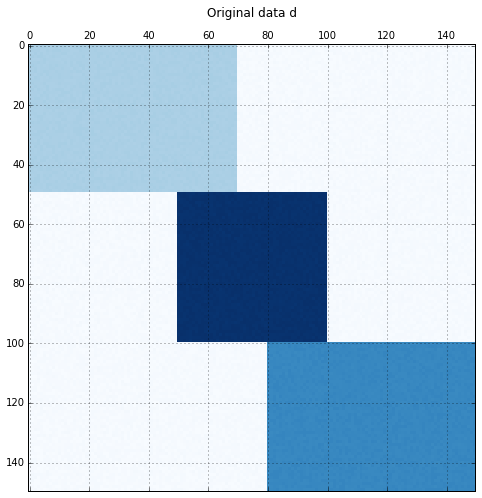

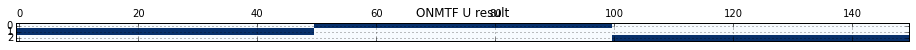

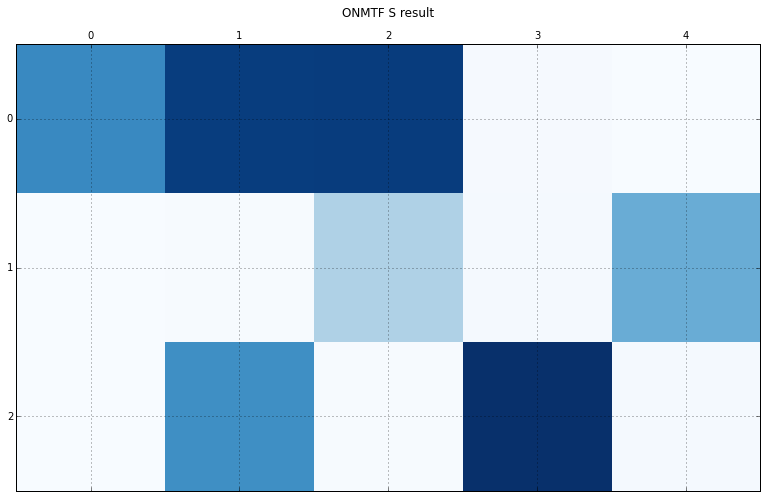

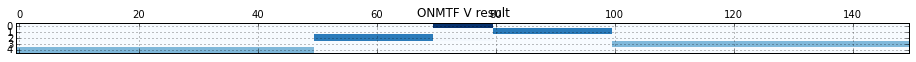

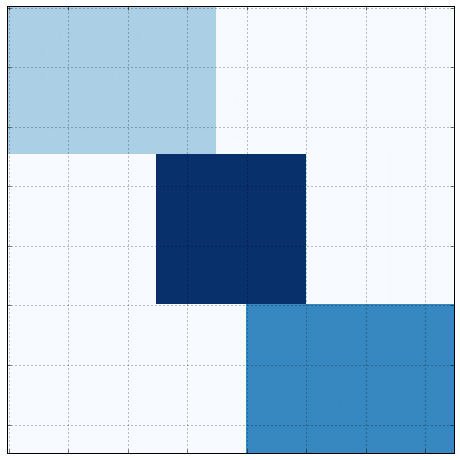

In [24]:
data_format_option = 'd'
X, y_row, y_col = generate_dataset(data_format_option, noise=10, noise_background=False)
n, m = X.shape

plt.matshow(X, cmap=plt.cm.Blues)
plt.title('Original data %s' % data_format_option)
plt.grid()
plt.show()

error = 10000.0
for i in xrange(10):
    U_t, S_t, V_t, rows_ind_t, cols_ind_t, error_t = matrix_factorization_clustering(X, 3, 5, norm=False, num_iters=1000)
    if error_t < error or i == 0:
        U = U_t
        S = S_t
        V = V_t
        rows_ind = rows_ind_t
        cols_ind = cols_ind_t
        error = error_t

reconstruction = U.dot(S).dot(V.T)

plt.matshow(U.T, cmap=plt.cm.Blues)
plt.title('ONMTF U result')
plt.grid()
plt.show()

plt.matshow(S, cmap=plt.cm.Blues)
plt.title('ONMTF S result')
plt.grid()
plt.show()

plt.matshow(V.T, cmap=plt.cm.Blues)
plt.title('ONMTF V result')
plt.grid()
plt.show()

plt.matshow(reconstruction, cmap=plt.cm.Blues)
plt.tick_params(labeltop=False, labelbottom=False, labelright=False, labelleft=False)
# plt.savefig('/Users/lucasbrunialti/git/masters-dissertation/img/%s-perfect-reconstruction-onmtf.png' % data_format_option)
plt.grid()
plt.show()

# Block Value Decomposition

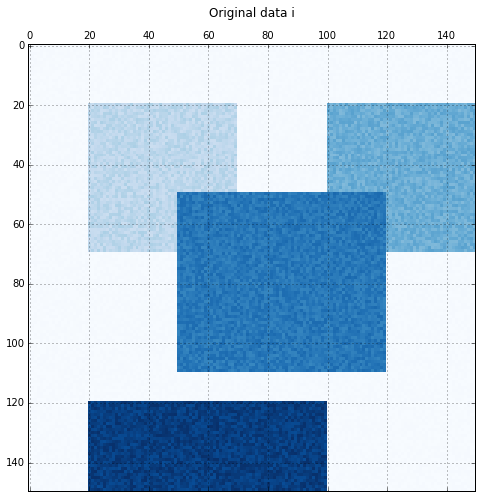

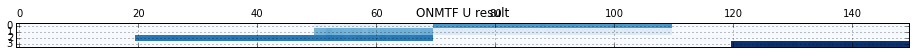

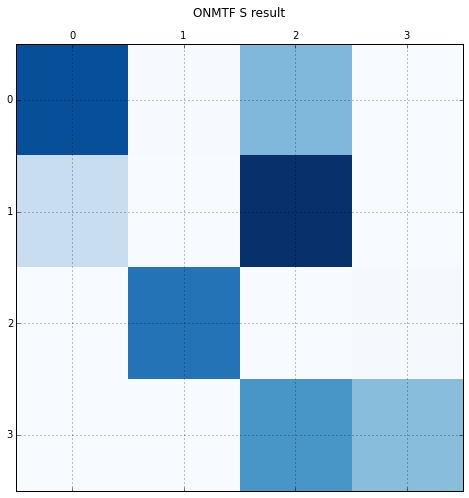

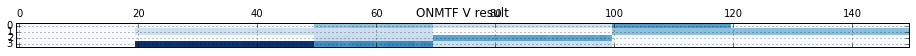

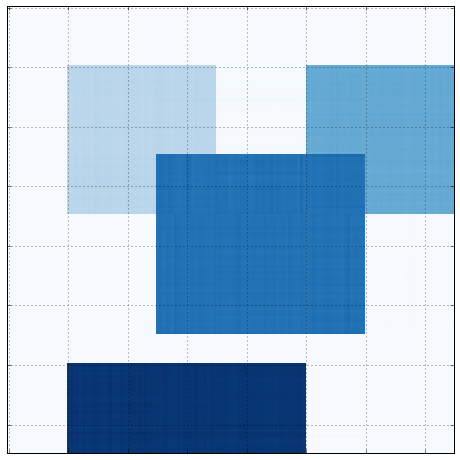

Error: 86988.1126004
-----------------------------------------------


In [91]:
from __future__ import division 
params = {
    'k' : {
        'a' : 2, 'b' : 3, 'c' : 3, 'd' : 3, 'e': 3, 'i': 4
    },
    'l' : {
        'a' : 2, 'b' : 3, 'c' : 3, 'd' : 3, 'e': 3, 'i': 4
    }
}

def onmtf(X, U, S, V):
    U = U * ((X.dot(V).dot(S.T)) / (U.dot(S).dot(V.T).dot(X.T).dot(U)))
    V = V * ((X.T.dot(U).dot(S)) / (V.dot(S.T).dot(U.T).dot(X).dot(V)))
    S = S * ((U.T.dot(X).dot(V)) / (U.T.dot(U).dot(S).dot(V.T).dot(V)))
    return U, S, V

def onm3f(X, U, S, V):
     U = U * (X.dot(V).dot(S.T)) / np.sqrt(U.dot(U.T).dot(X).dot(V).dot(S.T))
     V = V * (X.T.dot(U).dot(S)) / np.sqrt(V.dot(V.T).dot(X.T).dot(U).dot(S))
     S = S * (U.T.dot(X).dot(V)) / np.sqrt(U.T.dot(U).dot(S).dot(V.T).dot(V))
     return U, S, V

def nbvd(X, U, S, V):
     U = U * (X.dot(V).dot(S.T)) / U.dot(S).dot(V.T).dot(V).dot(S.T)
     V = V * (X.T.dot(U).dot(S)) / V.dot(S.T).dot(U.T).dot(U).dot(S)
     S = S * (U.T.dot(X).dot(V)) / U.T.dot(U).dot(S).dot(V.T).dot(V)
     return U, S, V
    
def matrix_factorization_clustering(X, k, l, factorization_func=nbvd, norm=False, num_iters=1000):
    m, n = X.shape
    U = np.random.rand(m,k)
    S = np.random.rand(k,l)
    V = np.random.rand(n,l)

    if norm:
        X = Normalizer().fit_transform(X)

    for i in xrange(num_iters):
        U, S, V = factorization_func(X, U, S, V)
        error = np.sum((X - U.dot(S).dot(V.T)) ** 2)

#     Du = np.diag(np.ones(m).dot(U))
#     Dv = np.diag(np.ones(n).dot(V))

#     U = U.dot( np.diag(S.dot(Dv).dot(np.ones(l))) )
#     V = V.dot( np.diag(np.ones(k).dot(Du).dot(S)) )

    rows_ind = np.argmax(U, axis=1)
    cols_ind = np.argmax(V, axis=1)

    return U, S, V, rows_ind, cols_ind, error

# for data_format_option in ['a', 'b', 'c', 'd', 'e']:
for data_format_option in ['i']:
    X, y_row, y_col = generate_dataset(data_format_option, noise=10, noise_background=False)
    n, m = X.shape

    plt.matshow(X, cmap=plt.cm.Blues)
    plt.title('Original data %s' % data_format_option)
    plt.grid()
    plt.show()

    error = np.inf
    for i in xrange(5):
        U_t, S_t, V_t, rows_ind_t, cols_ind_t, error_t = matrix_factorization_clustering(X,
                                                                     params['k'][data_format_option],
                                                                     params['l'][data_format_option],
                                                                     norm=False, num_iters=1000)
        if error_t < error or i == 0:
            U = U_t
            S = S_t
            V = V_t
            rows_ind = rows_ind_t
            cols_ind = cols_ind_t
            error = error_t

    reconstruction = U.dot(S).dot(V.T)

    plt.matshow(U.T, cmap=plt.cm.Blues)
    plt.title('ONMTF U result')
    plt.grid()
    plt.show()

    plt.matshow(S, cmap=plt.cm.Blues)
    plt.title('ONMTF S result')
    plt.grid()
    plt.show()

    plt.matshow(V.T, cmap=plt.cm.Blues)
    plt.title('ONMTF V result')
    plt.grid()
    plt.show()

    plt.matshow(reconstruction, cmap=plt.cm.Blues)
#     plt.title('ONMTF reconstruction result')
    plt.tick_params(labeltop=False, labelbottom=False, labelright=False, labelleft=False)
#     if data_format_option == 'b':
    plt.grid()
#     plt.savefig('/Users/lucasbrunialti/git/masters-dissertation/img/%s-reconstruction-onmtf.png' % data_format_option)
    plt.show()

#     print 'Rand score: %s' % adjusted_rand_score(y_row, rows_ind)
    print 'Error: %s' % error
    print '-----------------------------------------------'

## Fast Non-negative Matrix Tri-Factorization

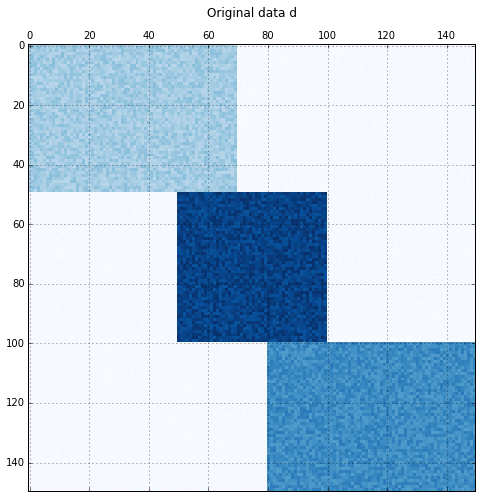

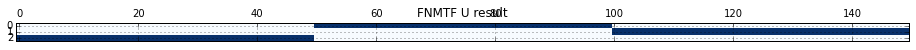

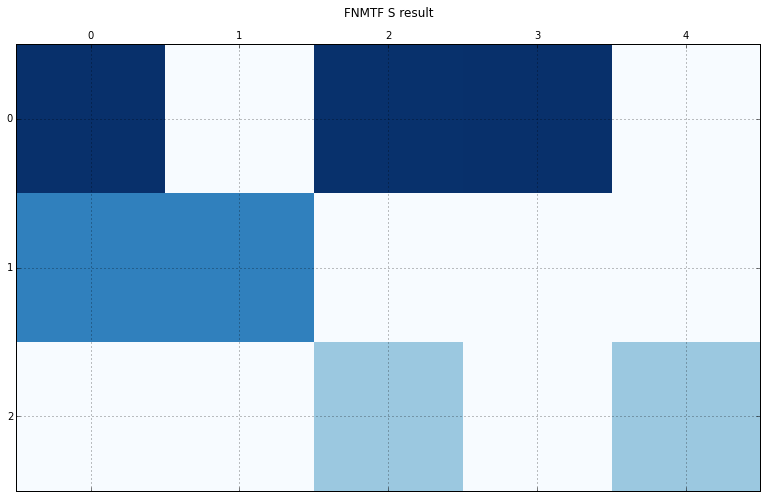

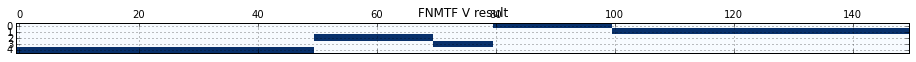

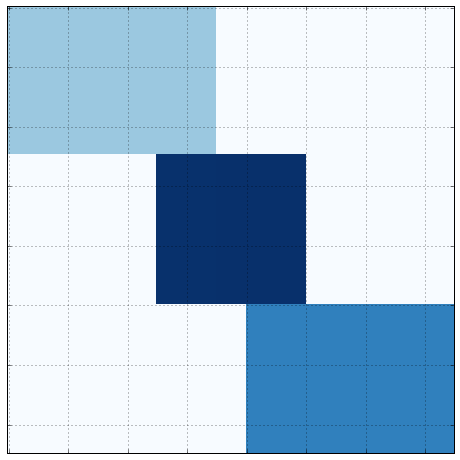

Rand score: 1.0
Error: 80618.2416402
-----------------------------------------------


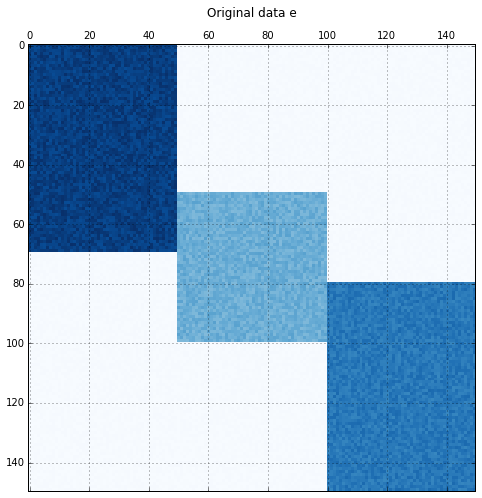

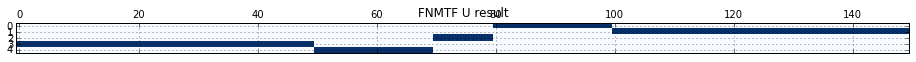

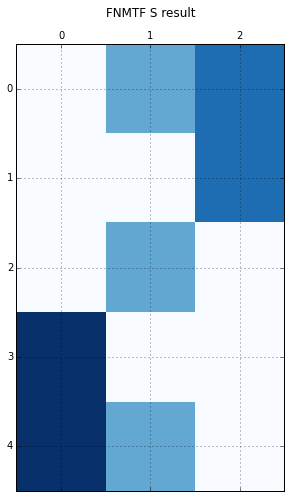

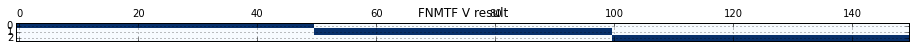

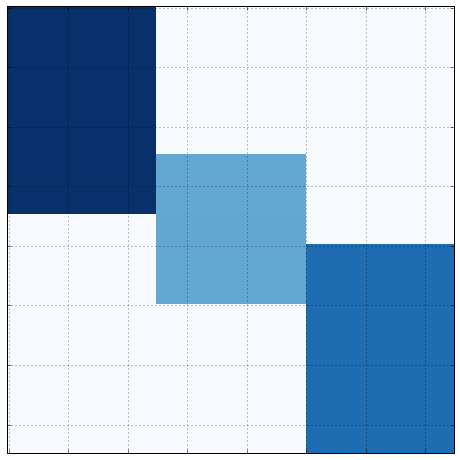

Rand score: 0.752742693832
Error: 78976.7667092
-----------------------------------------------


In [50]:
params = {
    'k' : {
        'a' : 2, 'b' : 3, 'c' : 3, 'd' : 3, 'e': 5
    },
    'l' : {
        'a' : 2, 'b' : 3, 'c' : 3, 'd' : 5, 'e': 3
    }
}

def fnmtf(X, k, l, num_iter=300, norm=False):
    m, n = X.shape

    U = np.random.rand(m,k)
    S = np.random.rand(k,l)
    V = np.random.rand(n,l)

    error_best = np.inf

    if norm:
        X = Normalizer().fit_transform(X)
    for _ in xrange(num_iter):
        S = np.linalg.pinv(U.T.dot(U)).dot(U.T).dot(X).dot(V).dot(np.linalg.pinv(V.T.dot(V)))

        # solve subproblem to update V
        U_tilde = U.dot(S)
        V_new = np.zeros(n*l).reshape(n, l)
        for j in xrange(n):
            errors = np.zeros(l)
            for col_clust_ind in xrange(l):
                errors[col_clust_ind] = ((X[:][:, j] - U_tilde[:][:, col_clust_ind])**2).sum()
            ind = np.argmin(errors)
            V_new[j][ind] = 1
        V = V_new

        while np.linalg.det(V.T.dot(V)) <= 0:
            if np.isnan( np.sum(V) ):
                break

            erros = (X - U.dot(S).dot(V.T)) ** 2
            erros = np.sum(erros.dot(V), axis=0) / np.sum(V, axis=0)
            erros[np.where(np.sum(V, axis=0) <= 1)] = -np.inf
            quantidade = np.sum(V, axis=0)
            indexMin = np.argmin(quantidade)
            indexMax = np.argmax(erros)
            indexes = np.nonzero(V[:, indexMax])[0]
            end = len(indexes)
            indexes_p = np.random.permutation(end)
            V[indexes[indexes_p[0:np.floor(end/2.0)]], indexMax] = 0.0
            V[indexes[indexes_p[0:np.floor(end/2.0)]], indexMin] = 1.0

        # solve subproblem to update U
        V_tilde = S.dot(V.T)
        U_new = np.zeros(m*k).reshape(m, k)
        for i in xrange(m):
            errors = np.zeros(k)
            for row_clust_ind in xrange(k):
                errors[row_clust_ind] = ((X[i][:] - V_tilde[row_clust_ind][:])**2).sum()
            ind = np.argmin(errors)
            U_new[i][ind] = 1
        U = U_new

        while np.linalg.det(U.T.dot(U)) <= 0:
            if np.isnan( np.sum(U) ):
                break

            erros = (X - U.dot(V_tilde)) ** 2
            erros = np.sum(U.T.dot(erros), axis=1) / np.sum(U, axis=0)
            erros[np.where(np.sum(U, axis=0) <= 1)] = -np.inf
            quantidade = np.sum(U, axis=0)
            indexMin = np.argmin(quantidade)
            indexMax = np.argmax(erros)
            indexes = np.nonzero(U[:, indexMax])[0]

            end = len(indexes)
            indexes_p = np.random.permutation(end)
            U[indexes[indexes_p[0:np.floor(end/2.0)]], indexMax] = 0.0
            U[indexes[indexes_p[0:np.floor(end/2.0)]], indexMin] = 1.0

        error = np.sum((X - U.dot(S).dot(V.T)) ** 2)

        if error < error_best:
            U_best = U
            S_best = S
            V_best = V
            error_best = error

    rows_ind = np.argmax(U, axis=1)
    cols_ind = np.argmax(V, axis=1)

    

    return U, S, V, rows_ind, cols_ind, error

# for data_format_option in ['a', 'b', 'c', 'd', 'e']:
for data_format_option in ['d', 'e']:
    X, y_row, y_col = generate_dataset(data_format_option, noise=10, noise_background=False)
    n, m = X.shape

    plt.matshow(X, cmap=plt.cm.Blues)
    plt.title('Original data %s' % data_format_option)
    plt.grid()
    plt.show()

    error = np.inf
    for i in xrange(10):
        U_t, S_t, V_t, rows_ind_t, cols_ind_t, error_t = fnmtf(X,
                                                             params['k'][data_format_option],
                                                             params['l'][data_format_option])
        if error_t < error:
            U = U_t
            S = S_t
            V = V_t
            rows_ind = rows_ind_t
            cols_ind = cols_ind_t
            error = error_t

    reconstruction = U.dot(S).dot(V.T)

    plt.matshow(U.T, cmap=plt.cm.Blues)
    plt.title('FNMTF U result')
    plt.grid()
    plt.show()

    plt.matshow(S, cmap=plt.cm.Blues)
    plt.title('FNMTF S result')
    plt.grid()
    plt.show()

    plt.matshow(V.T, cmap=plt.cm.Blues)
    plt.title('FNMTF V result')
    plt.grid()
    plt.show()

    plt.matshow(reconstruction, cmap=plt.cm.Blues)
#     plt.title('FNMTF reconstruction result')
    plt.grid()
    plt.tick_params(labeltop=False, labelbottom=False, labelright=False, labelleft=False)
#     if data_format_option == 'b':
    plt.savefig('/Users/lucasbrunialti/git/masters-dissertation/img/%s-reconstruction-2-fnmtf.png' % data_format_option)
    plt.show()

    print 'Rand score: %s' % adjusted_rand_score(y_row, rows_ind)
    print 'Error: %s' % error
    print '-----------------------------------------------'

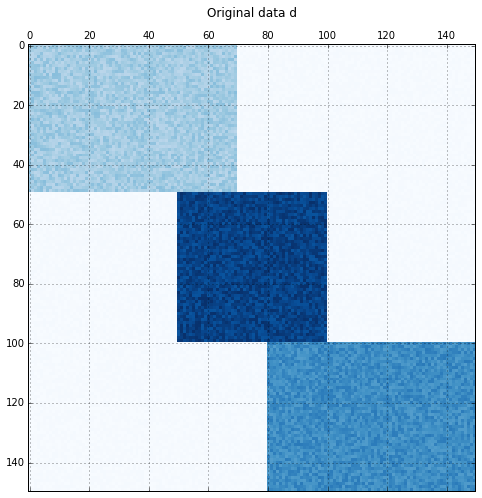

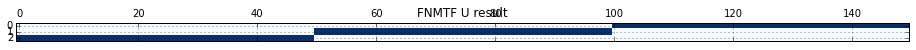

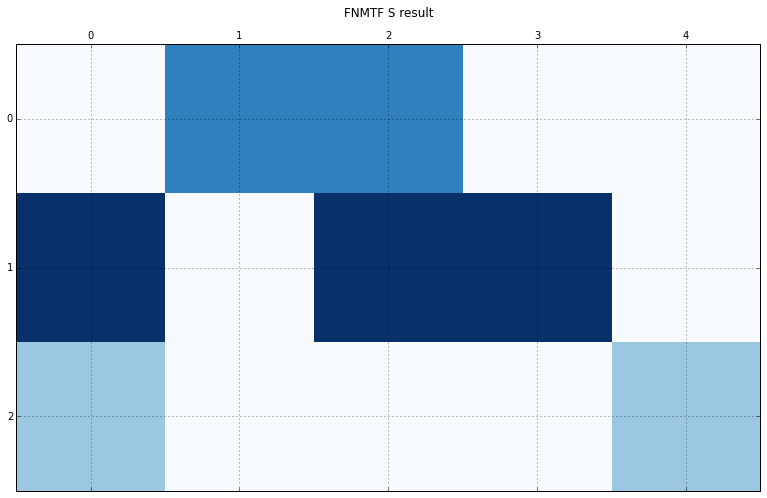

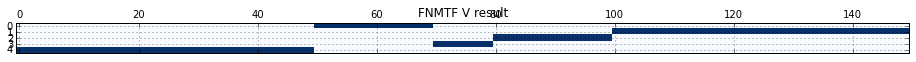

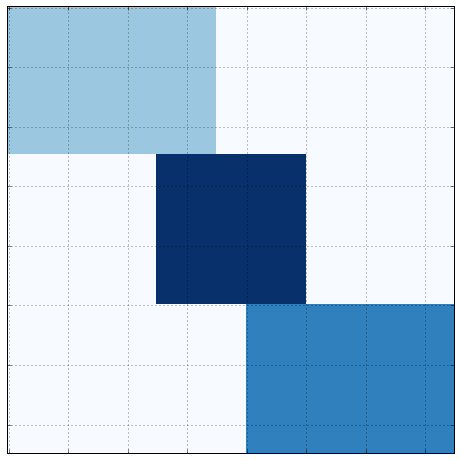

In [26]:
data_format_option = 'd'
X, y_row, y_col = generate_dataset(data_format_option, noise=10, noise_background=False)
n, m = X.shape

plt.matshow(X, cmap=plt.cm.Blues)
plt.title('Original data %s' % data_format_option)
plt.grid()
plt.show()

error = np.inf
for i in xrange(10):
    U_t, S_t, V_t, rows_ind_t, cols_ind_t, error_t = fnmtf(X, 3, 5)
    if error_t < error:
        U = U_t
        S = S_t
        V = V_t
        rows_ind = rows_ind_t
        cols_ind = cols_ind_t
        error = error_t

reconstruction = U.dot(S).dot(V.T)

plt.matshow(U.T, cmap=plt.cm.Blues)
plt.title('FNMTF U result')
plt.grid()
plt.show()

plt.matshow(S, cmap=plt.cm.Blues)
plt.title('FNMTF S result')
plt.grid()
plt.show()

plt.matshow(V.T, cmap=plt.cm.Blues)
plt.title('FNMTF V result')
plt.grid()
plt.show()

plt.matshow(reconstruction, cmap=plt.cm.Blues)
#     plt.title('FNMTF reconstruction result')
plt.grid()
plt.tick_params(labeltop=False, labelbottom=False, labelright=False, labelleft=False)
#     if data_format_option == 'b':
plt.savefig('/Users/lucasbrunialti/git/masters-dissertation/img/%s-perfect-reconstruction-fnmtf.png' % data_format_option)
plt.show()

## Fast Overlapping Non-negative Matrix Tri-Factorization

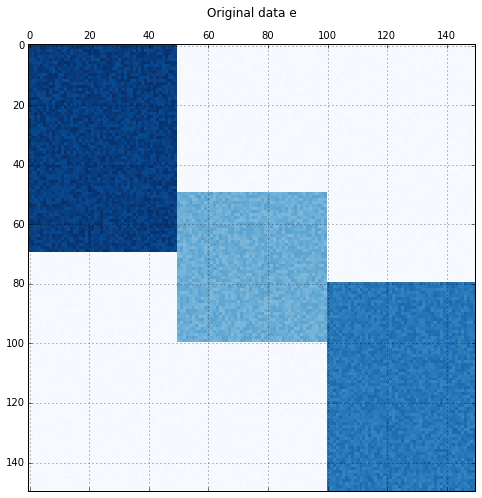

(150, 3)
(150, 3)
(150, 3)
(150, 3)
(150, 3)


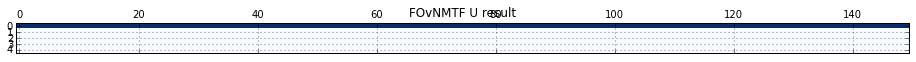

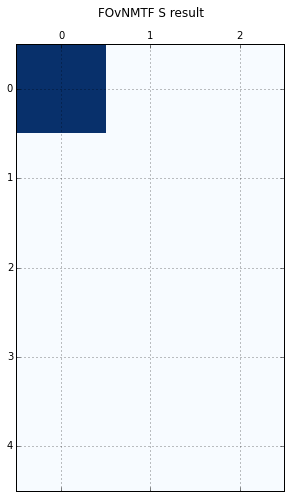

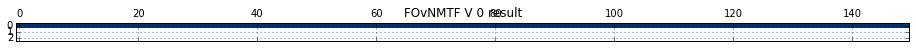

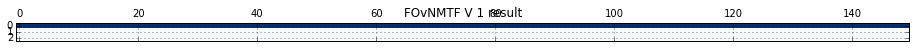

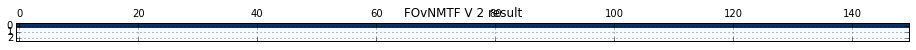

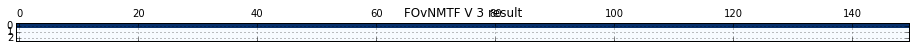

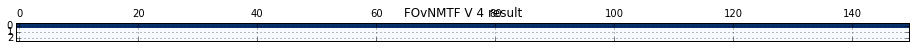

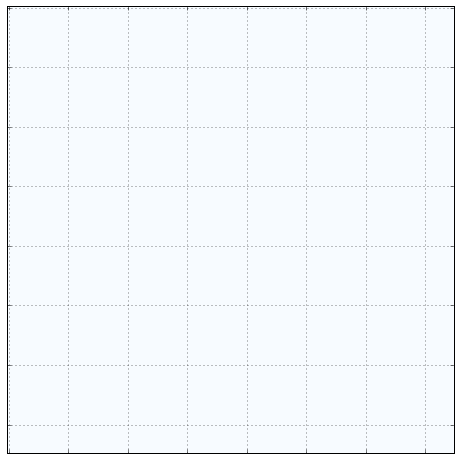

Rand score: 0.0
Error: 26767977.7882
-----------------------------------------------


In [24]:
params = {
    'k' : {
        'a' : 2, 'b' : 3, 'c' : 3, 'd' : 3, 'e': 5
    },
    'l' : {
        'a' : 2, 'b' : 2, 'c' : 3, 'd' : 2, 'e': 3
    }
}

def matrix_factorization_overlapping_bin(X, k, l, num_iters=1000):
    def weights_initialization(X, n, m, k):
        shuffle_inds = np.random.permutation(n)
        cluster_end_ind = 0
        for i in xrange(k):
            cluster_init_ind = cluster_end_ind
            cluster_end_ind = round((i + 1) * n / k)
            X[shuffle_inds[cluster_init_ind : cluster_end_ind], i] = 1
#         return X
        print X.shape
        return np.random.rand(X.shape[0],X.shape[1])

    def calculate_block_matrix(X, F, G, S, k, l):
        for i in xrange(k):
            for j in xrange(l):
                S[i, j] = np.mean(X[F[:, i] == 1][:, G[i][:, j] == 1])
        where_are_NaNs = np.isnan(S)
        S[where_are_NaNs] = 0
        return S

    n, m = X.shape

    error_best = np.inf

#     F = weights_initialization(np.zeros((n, k)), n, m, k)
    F = np.random.rand(n, k)

    G = []
    for i in xrange(k):
        G.append( weights_initialization(np.zeros((m, l)), m, n, l) )

    S = np.random.rand(k, l)

    for iter_ind in xrange(num_iters):
#         S = calculate_block_matrix(X, F, G, S, k, l)
        for p in xrange(k):
            S[p, :] = (np.linalg.pinv(F.T.dot(F)).dot(F.T).dot(X).dot(G[p]).dot(np.linalg.pinv(G[p].T.dot(G[p]))))[p, :]

        # Update G
        for i in xrange(k):
            F_t = F[:, i].reshape(n, 1).dot(S[i, :].reshape(1, l))
#             X_t = X[F[:, i] == 1, :]
            X_t = X
            G[i] = np.zeros((m, l))
            for j in xrange(m):
                errors = np.zeros(l)
                for q in xrange(l):
                    errors[q] = np.sum((X_t[:, j] - F_t[:, q]) ** 2)
                ind = np.argmin(errors)
                G[i][j, ind] = 1.0

#             while np.linalg.det(G[i].T.dot(G[i])) <= 0:
#                 erros = (X_t - F_t.dot(G[i].T)) ** 2
#                 erros = np.sum(erros.dot(G[i]), axis=0) / np.sum(G[i], axis=0)
#                 erros[np.where(np.sum(G[i], axis=0) <= 1)] = -np.inf
#                 quantidade = np.sum(G[i], axis=0)
#                 indexMin = np.argmin(quantidade)
#                 indexMax = np.argmax(erros)
#                 indexes = np.nonzero(G[i][:, indexMax])[0]

#                 end = len(indexes)
#                 indexes_p = np.random.permutation(end)
#                 G[i][indexes[indexes_p[0:np.floor(end/2.0)]], indexMax] = 0.0
#                 G[i][indexes[indexes_p[0:np.floor(end/2.0)]], indexMin] = 1.0
# #                 for j in indexes:
# #                     G[i][j, indexMax] = 0.0
# #                     G[i][j, indexMin] = 1.0

        S = calculate_block_matrix(X, F, G, S, k, l)

        G_t = np.zeros((k, m))
        for i in xrange(k):
            G_t[i, :] = S[i, :].dot(G[i].T)

        F = np.zeros((n, k))
        for j in xrange(n):
            errors = np.zeros(k)
            for p in xrange(k):
                errors[p] = np.sum((X[j, :] - G_t[p, :]) ** 2)
            ind = np.argmin(errors)
            F[j, ind] = 1.0

#         while np.linalg.det(F.T.dot(F)) <= 0:
#             erros = (X - F.dot(G_t)) ** 2
#             erros = np.sum(F.T.dot(erros), axis=1) / np.sum(F, axis=0)
#             erros[np.where(np.sum(F, axis=0) <= 1)] = -np.inf
#             quantidade = np.sum(F, axis=0)
#             indexMin = np.argmin(quantidade)
#             indexMax = np.argmax(erros)
#             indexes = np.nonzero(F[:, indexMax])[0]

#             end = len(indexes)
#             indexes_p = np.random.permutation(end)
#             F[indexes[indexes_p[0:np.floor(end/2.0)]], indexMax] = 0.0
#             F[indexes[indexes_p[0:np.floor(end/2.0)]], indexMin] = 1.0

        error = np.sum((X - F.dot(G_t))**2)
#         print error

        if error < error_best:
            error_best = error
            F_best = F
            S_best = S
            G_best = G
            G_t_best = G_t

    rows_ind = np.argmax(F_best, axis=1)
    reconstruction = F_best.dot(G_t_best)

    return F, S, G, G_t, rows_ind, error_best, reconstruction

# for data_format_option in ['a', 'b', 'c', 'd', 'e']:
for data_format_option in ['e']:
    X, y_row, y_col = generate_dataset(data_format_option, noise=10, noise_background=False)
    n, m = X.shape

    plt.matshow(X, cmap=plt.cm.Blues)
    plt.title('Original data %s' % data_format_option)
    plt.grid()
    plt.show()

    error = 10000.0
    for i in xrange(1):
        U_t, S_t, V_t, V_t_t, rows_ind_t, error_t, reconstruction_t = matrix_factorization_overlapping_bin(
                                                             X,
                                                             params['k'][data_format_option],
                                                             params['l'][data_format_option])
        if error_t < error or i == 0:
            U = U_t
            S = S_t
            V = V_t
            V_tilde = V_t_t
            rows_ind = rows_ind_t
            error = error_t
            reconstruction = reconstruction_t

    plt.matshow(U.T, cmap=plt.cm.Blues)
    plt.title('FOvNMTF U result')
    plt.grid()
    plt.show()

    plt.matshow(S, cmap=plt.cm.Blues)
    plt.title('FOvNMTF S result')
    plt.grid()
    plt.show()
    S

    for j in xrange(params['k'][data_format_option]):
        plt.matshow(V[j].T, cmap=plt.cm.Blues)
        plt.title('FOvNMTF V %s result' % j)
        plt.grid()
        plt.show()

    plt.matshow(reconstruction, cmap=plt.cm.Blues)
#     plt.title('FOvNMTF reconstruction result')
    plt.grid()
    plt.tick_params(labeltop=False, labelbottom=False, labelright=False, labelleft=False)
#     if data_format_option == 'b':
#     plt.savefig('/Users/lucasbrunialti/git/masters-dissertation/img/%s-reconstruction-2-binovnmtf.png' % data_format_option)
    plt.show()

    print 'Rand score: %s' % adjusted_rand_score(y_row, rows_ind)
    print 'Error: %s' % error
    print '-----------------------------------------------'

## Overlapping Non-Negative Matrix Tri-Factorization

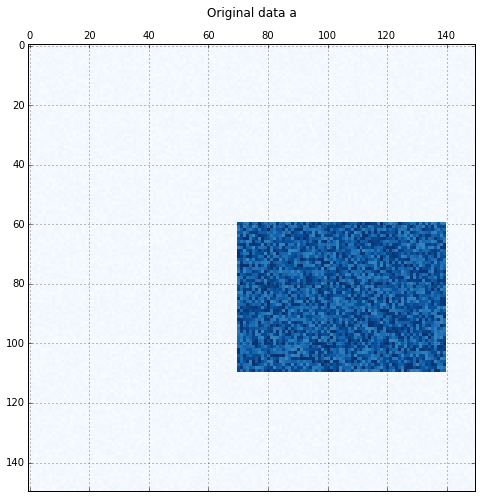

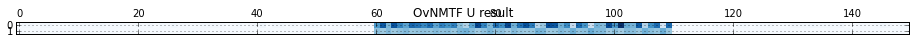

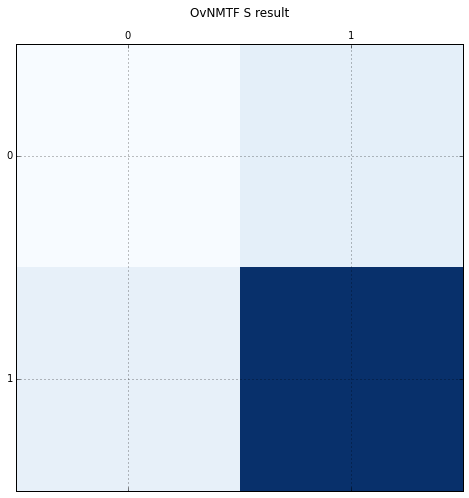

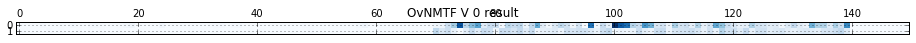

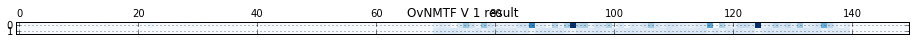

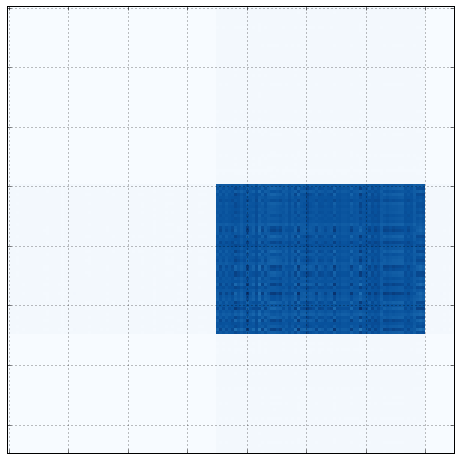

Rand score: 0.000193653959739
Error: 30439.8290109
-----------------------------------------------


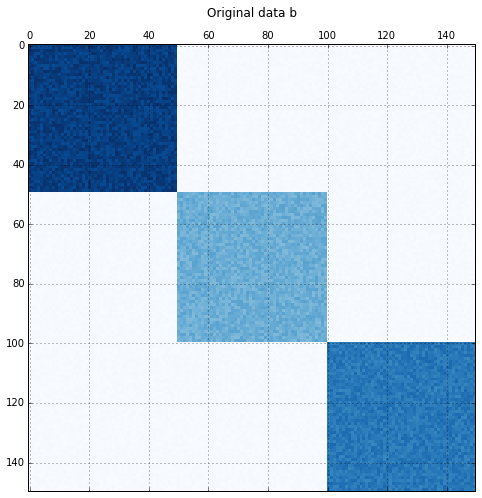

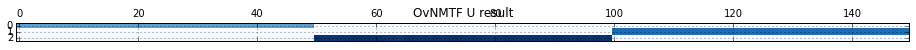

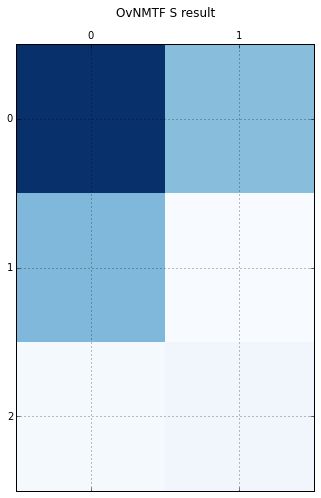

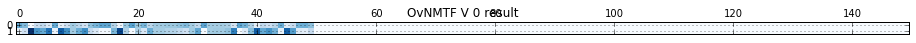

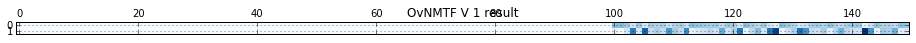

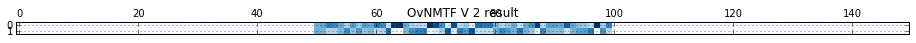

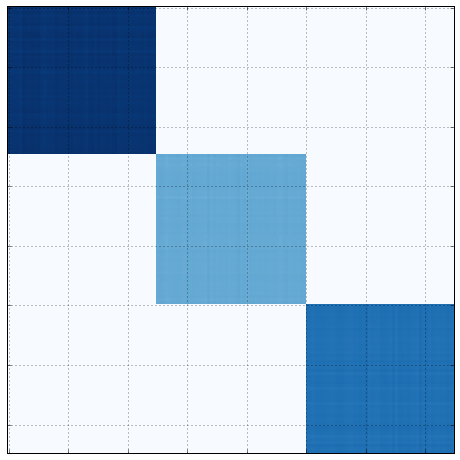

Rand score: 1.0
Error: 61863.1647057
-----------------------------------------------


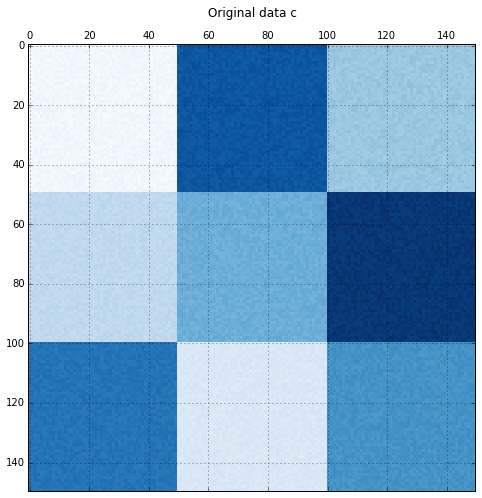

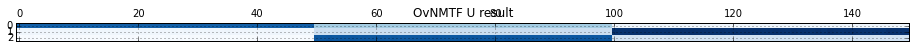

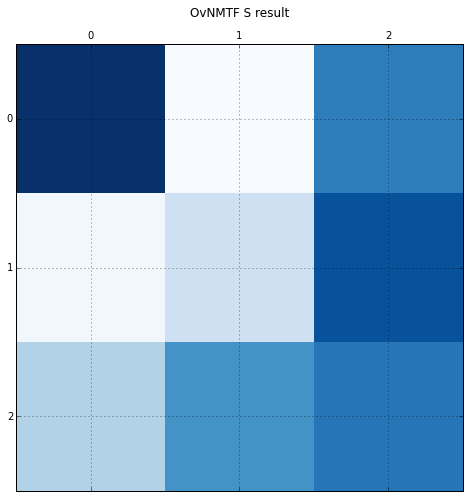

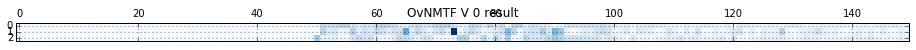

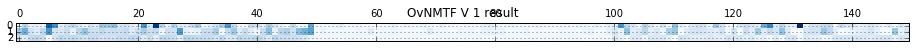

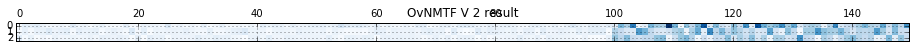

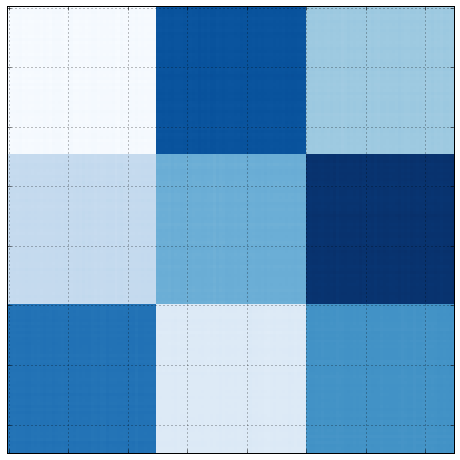

Rand score: 1.0
Error: 178886.791
-----------------------------------------------


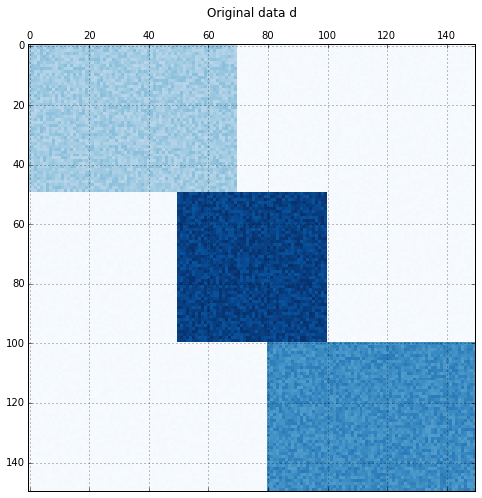

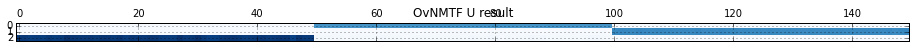

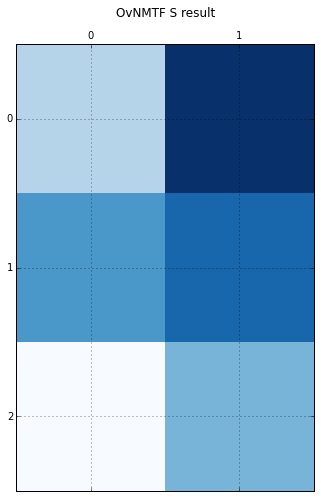

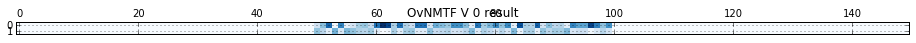

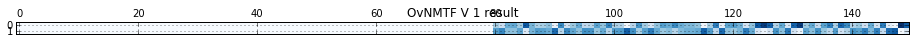

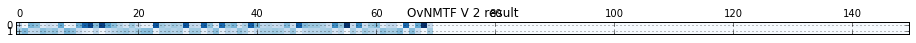

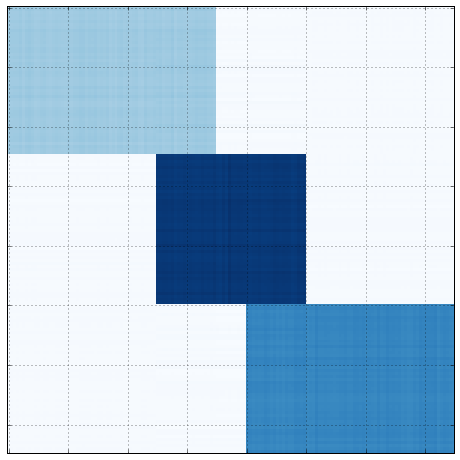

Rand score: 1.0
Error: 75533.5508622
-----------------------------------------------


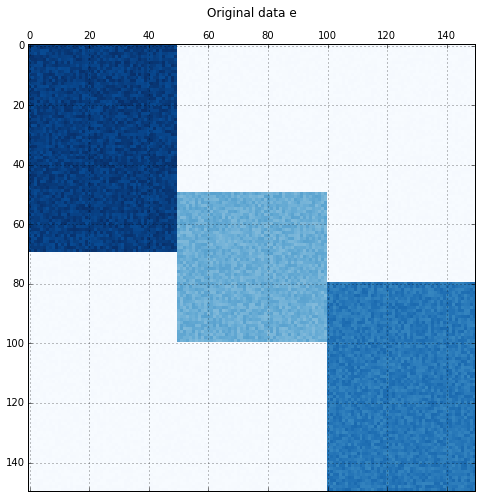

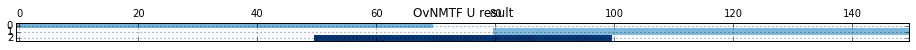

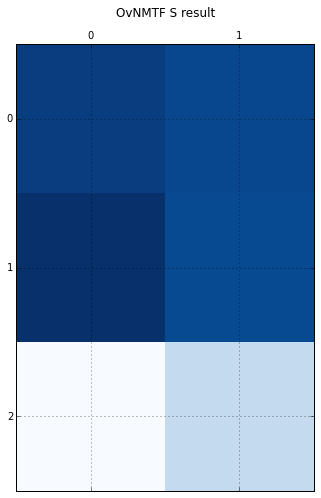

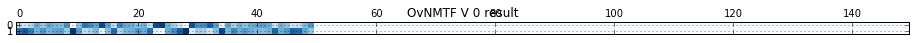

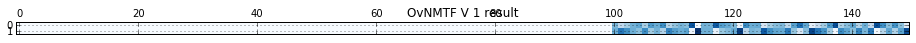

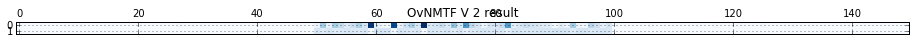

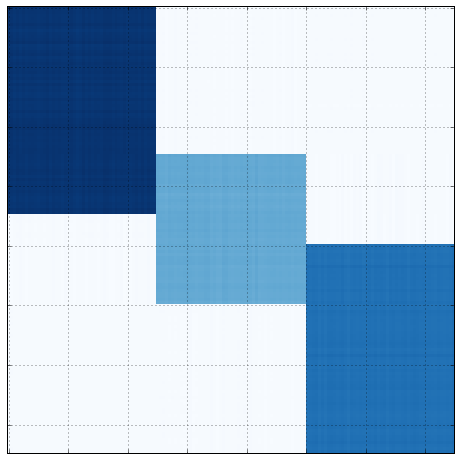

Rand score: 0.68440561292
Error: 75931.2166463
-----------------------------------------------


In [6]:
params = {
    'k' : {
        'a' : 2, 'b' : 3, 'c' : 3, 'd' : 3, 'e': 3
    },
    'l' : {
        'a' : 2, 'b' : 2, 'c' : 3, 'd' : 2, 'e': 2
    }
}

def is_any_clust_empty(U_bin):
    n, k = U_bin.shape
    return np.count_nonzero(np.sum(U_bin, axis=0)) != k

def overlapping_matrix_factorization_coclustering(X, k, l, norm=False, num_iters=100):
    n, m = X.shape
    U = np.random.rand(n, k)
    S = np.random.rand(k, l)
    V = []
    for i in xrange(k):
        V.append(np.random.rand(m, l))

    Ii = np.zeros((k, k))
    Ij = np.zeros((k, k))

    error_best = np.inf
    
    if norm:
        X = Normalizer().fit_transform(X)

    V_tilde = np.zeros((k, m))
    for i in xrange(k):
        Ii[i, i] = 1
        V_tilde += Ii.dot(S).dot(V[i].T)
        Ii[i, i] = 0
    error = np.sum((X - U.dot(V_tilde)) ** 2)

    for _ in xrange(num_iters):
        # Update U
        new_U_pos = np.zeros((n, k))
        new_U_neg = np.zeros((n, k))
        for i in xrange(k):
            Ii[i, i] = 1
            for j in xrange(k):
                Ij[j, j] = 1
                new_U_pos += U.dot(Ii).dot(S).dot(V[i].T).dot(V[j]).dot(S.T).dot(Ij)
                Ij[j, j] = 0
            new_U_neg += X.dot(V[i]).dot(S.T).dot(Ii)
            Ii[i, i] = 0
        U = U * (new_U_neg / new_U_pos)

        # Compute V'
        V_tilde = np.zeros((k, m))
        for i in xrange(k):
            Ii[i, i] = 1
            V_tilde += Ii.dot(S).dot(V[i].T)
            Ii[i, i] = 0

#         # Compute U binary
#         U_bin = np.zeros(U.shape)
#         rows_inds = np.argmax(U, axis=1)
#         for i in xrange(n):
#              U_bin[i, rows_inds[i]] = 1

#         # update U so that clusters are orthogonal
# #         import pdb; pdb.set_trace()
#         while is_any_clust_empty(U_bin):
# #             import pdb; pdb.set_trace()

#             if np.isnan( np.sum(U) ):
#                 break

#             erros = (X - U.dot(V_tilde)) ** 2
#             erros = np.sum(U.T.dot(erros), axis=1) / np.sum(U, axis=0)
#             erros[np.where(np.sum(U_bin, axis=0) <= 1)] = -np.inf
#             quantidade = np.sum(U_bin, axis=0)
#             indexMin = np.argmin(quantidade)
#             indexMax = np.argmax(erros)
#             indexes = np.nonzero(U_bin[:, indexMax])[0]

#             end = len(indexes)
#             indexes_p = np.random.permutation(end)
#             aux = U[indexes[indexes_p[0:np.floor(end/2.0)]], indexMax]
#             U[indexes[indexes_p[0:np.floor(end/2.0)]], indexMax] = U[indexes[indexes_p[0:np.floor(end/2.0)]], indexMin]
#             U[indexes[indexes_p[0:np.floor(end/2.0)]], indexMin] = aux

#             # Recompute U binary for each iteration
#             U_bin = np.zeros(U.shape)
#             rows_inds = np.argmax(U, axis=1)
#             for i in xrange(n):
#                 U_bin[i, rows_inds[i]] = 1

        # Update Vi
        for i in xrange(k):
            new_V_pos = np.zeros((m, l))
            new_V_neg = np.zeros((m, l))
            Ii[i, i] = 1
            for j in xrange(k):
                Ij[j, j] = 1

                new_V_pos += V[j].dot(S.T).dot(Ij).dot(U.T).dot(U).dot(Ii).dot(S)

                Ij[j, j] = 0

            new_V_neg += X.T.dot(U).dot(Ii).dot(S)

            Ii[i, i] = 0
            V[i] = V[i] * (new_V_neg / new_V_pos)

        # Recompute V'
        V_tilde = np.zeros((k, m))
        for i in xrange(k):
            Ii[i, i] = 1
            V_tilde += Ii.dot(S).dot(V[i].T)
            Ii[i, i] = 0

#         # Compute Vs binary
#         V_bin = []
#         for i in xrange(k):
#             Vi_bin = np.zeros((l, m))
#             cols_inds = np.argmax(V[i], axis=0)
#             for j in xrange(m):
#                  Vi_bin[cols_inds[j], j] = 1
#             V_bin.append(Vi_bin)

#         # Update Vs so that clusters are orthogonal
#         for i in xrange(k):
#             while is_any_clust_empty(V_bin[i].T):
# #                 import pdb; pdb.set_trace()

#                 if np.isnan( np.sum(V[i]) ):
#                     break

#                 erros = (X - U.dot(V_tilde)) ** 2
#                 erros = np.sum(erros.dot(V[i].T), axis=0) / np.sum(V[i], axis=1)
#                 erros[np.where(np.sum(V_bin[i], axis=1) <= 1)] = -np.inf
#                 quantidade = np.sum(V_bin[i], axis=1)
#                 indexMin = np.argmin(quantidade)
#                 indexMax = np.argmax(erros)
#                 indexes = np.nonzero(V_bin[i][indexMax, :])[0]

#                 end = len(indexes)
#                 indexes_p = np.random.permutation(end)
#                 aux = V[i][indexMax, indexes[indexes_p[0:np.floor(end/2.0)]]]
#                 V[i][indexMax, indexes[indexes_p[0:np.floor(end/2.0)]]] = V[i][indexMin, indexes[indexes_p[0:np.floor(end/2.0)]]]
#                 V[i][indexMin, indexes[indexes_p[0:np.floor(end/2.0)]]] = aux
# #                 for j in indexes:
# #                     if np.random.rand(1) > 0.5:
# #                         aux = V[i][indexMax, j]
# #                         V[i][indexMax, j] = V[i][indexMin, j]
# #                         V[i][indexMin, j] = aux

#                 # Recompute Vs binary
#                 V_bin = []
#                 for ii in xrange(k):
#                     Vi_bin = np.zeros((l, m))
#                     cols_inds = np.argmax(V[ii], axis=0)
#                     for j in xrange(m):
#                          Vi_bin[cols_inds[j], j] = 1
#                     V_bin.append(Vi_bin)

#                 # Recompute V'
#                 V_tilde = np.zeros((k, m))
#                 for i in xrange(k):
#                     Ii[i, i] = 1
#                     V_tilde += Ii.dot(S).dot(V[i])
#                     Ii[i, i] = 0
            
        new_S_pos = np.zeros((k, l))
        new_S_neg = np.zeros((k, l))
        for i in xrange(k):
            Ii[i, i] = 1
            for j in xrange(k):
                Ij[j, j] = 1
                new_S_pos += Ii.dot(U.T).dot(U).dot(Ij).dot(S).dot(V[j].T).dot(V[i])
                Ij[j, j] = 0
            new_S_neg += Ii.dot(U.T).dot(X).dot(V[i])
            Ii[i, i] = 0
        S = S * (new_S_neg / new_S_pos)

#         import pdb; pdb.set_trace()

        V_tilde = np.zeros((k, m))
        for i in xrange(k):
            Ii[i, i] = 1
            V_tilde += Ii.dot(S).dot(V[i].T)
            Ii[i, i] = 0
        error = np.sum((X - U.dot(V_tilde)) ** 2)
#         print error

        if error < error_best:
            error_best = error
            U_best = U
            S_best = S
            V_best = V
            V_tilde_best = V_tilde

#     Du = np.diag(np.ones(m).dot(U))
#     Dv = np.diag(np.ones(n).dot(V))

#     U = U.dot( np.diag(S.dot(Dv).dot(np.ones(l))) )
#     V = V.dot( np.diag(np.ones(k).dot(Du).dot(S)) )

    rows_ind = np.argmax(U_best, axis=1)
#     cols_ind = np.argmax(V, axis=1)
    reconstruction = U_best.dot(V_tilde_best)

    return U_best, S_best, V_best, V_tilde, rows_ind, error_best, reconstruction

for data_format_option in ['a', 'b', 'c', 'd', 'e']:
    X, y_row, y_col = generate_dataset(data_format_option, noise=10, noise_background=False)
    n, m = X.shape

    plt.matshow(X, cmap=plt.cm.Blues)
    plt.title('Original data %s' % data_format_option)
    plt.grid()
    plt.show()

#     plt.matshow(Normalizer().fit_transform(X), cmap=plt.cm.Blues)
#     plt.title('Original data normalized %s' % data_format_option)
#     plt.grid()
#     plt.show()

    error = np.inf
    for i in xrange(10):
        U_t, S_t, V_t, V_t_t, rows_ind_t, error_t, reconstruction_t = overlapping_matrix_factorization_coclustering(
                                                             X,
                                                             params['k'][data_format_option],
                                                             params['l'][data_format_option],
                                                             norm=False,
                                                             num_iters=1000)
        if error_t < error or i == 0:
            U = U_t
            S = S_t
            V = V_t
            V_tilde = V_t_t
            rows_ind = rows_ind_t
            error = error_t
            reconstruction = reconstruction_t

    plt.matshow(U.T, cmap=plt.cm.Blues)
    plt.title('OvNMTF U result')
    plt.grid()
    plt.show()

    plt.matshow(S, cmap=plt.cm.Blues)
    plt.title('OvNMTF S result')
    plt.grid()
    plt.show()

    for j in xrange(params['k'][data_format_option]):
        plt.matshow(V[j].T, cmap=plt.cm.Blues)
        plt.title('OvNMTF V %s result' % j)
        plt.grid()
        plt.show()

    plt.matshow(reconstruction, cmap=plt.cm.Blues)
#     plt.title('OvNMTF reconstruction result')

    plt.grid()
    plt.tick_params(labeltop=False, labelbottom=False, labelright=False, labelleft=False)
    plt.savefig('/Users/lucasbrunialti/git/masters-dissertation/img/%s-reconstruction-ovnmtf.png' % data_format_option)
    plt.show()

    print 'Rand score: %s' % adjusted_rand_score(y_row, rows_ind)
    print 'Error: %s' % error
    print '-----------------------------------------------'

In [ ]:
d = np.array([5, 5, 5, 0.4, 5, 5, 5, 0.1, 0.4, 7, 7, 7, 0.2, 7, 7, 7, 10, 10, 10, 10, 10, 10, 10, 10]).reshape((6,4))
print d.shape

plt.matshow(d, cmap=plt.cm.Blues)
plt.grid()
plt.show()

U, S, V, V_t, rows_ind, error, reconstruction = matrix_factorization_overlapping_bin(d, 3, 2)

plt.matshow(U.T, cmap=plt.cm.Blues)
plt.title('FOvNMTF U result')
plt.grid()
plt.show()

plt.matshow(S, cmap=plt.cm.Blues)
plt.title('FOvNMTF S result')
plt.grid()
plt.show()
for j in range(3):
    plt.matshow(V[j].T, cmap=plt.cm.Blues)
    plt.title('FOvNMTF V %s result' % j)
    plt.grid()
    plt.show()

plt.matshow(reconstruction, cmap=plt.cm.Blues)
plt.grid()
plt.tick_params(labeltop=False, labelbottom=False, labelright=False, labelleft=False)
plt.show()

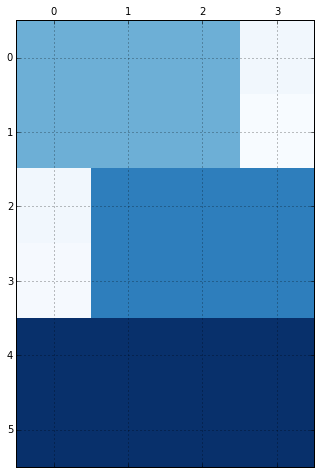

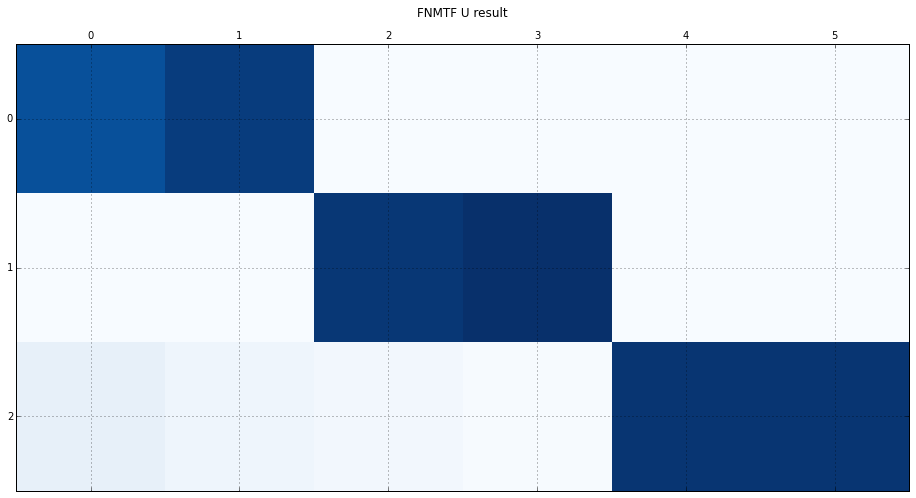

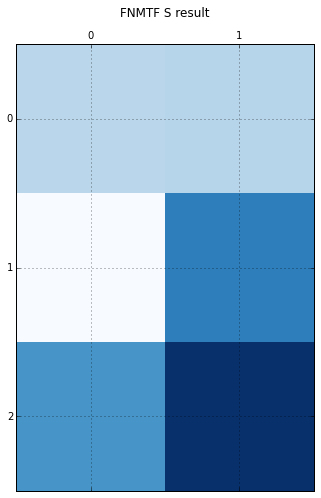

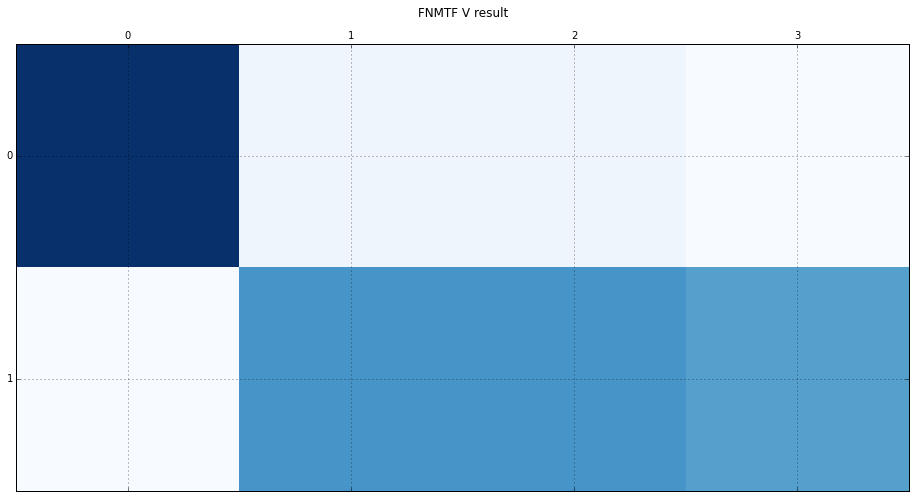

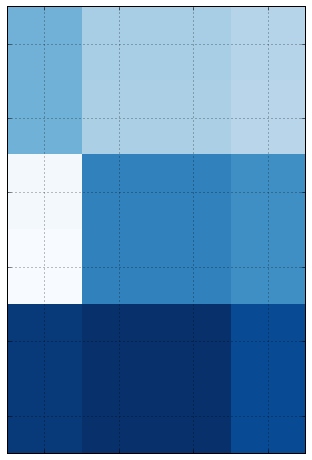

In [61]:
d = np.array([5, 5, 5, 0.4, 5, 5, 5, 0.1, 0.4, 7, 7, 7, 0.2, 7, 7, 7, 10, 10, 10, 10, 10, 10, 10, 10]).reshape((6,4))

plt.matshow(d, cmap=plt.cm.Blues)
plt.grid()
plt.show()

U, S, V, rows_ind, cols_ind, error = matrix_factorization_clustering(d, 3, 2)

reconstruction = U.dot(S).dot(V.T)

plt.matshow(U.T, cmap=plt.cm.Blues)
plt.title('FNMTF U result')
plt.grid()
plt.show()

plt.matshow(S, cmap=plt.cm.Blues)
plt.title('FNMTF S result')
plt.grid()
plt.show()

plt.matshow(V.T, cmap=plt.cm.Blues)
plt.title('FNMTF V result')
plt.grid()
plt.show()

plt.matshow(reconstruction, cmap=plt.cm.Blues)
plt.grid()
plt.tick_params(labeltop=False, labelbottom=False, labelright=False, labelleft=False)
plt.show()